## Melanoma - Skin Cancer detection using CNN
### <font color="green">Gadicherla Sameer</font>
### Batch : Match 31' 2021

### **Problem statement:**
- To build a CNN based model which can accurately detect melanoma. 
- Melanoma is a type of cancer that can be deadly if not detected early. 
- It accounts for 75% of skin cancer deaths. 
- A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/melanomaData/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab Notebooks/melanomaData/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
##  Creating train dataset here
## Using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resizing images to the size img_height*img_width, while writting the dataset
train_ds = image_dataset_from_directory(
    data_dir_train,
    class_names=None, batch_size=batch_size, image_size=(img_height,
    img_width), seed=123, validation_split=0.2,subset="training"
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
##  Creating validation dataset here
## Using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
## Resizing images to the size img_height*img_width, while writting the dataset
val_ds = image_dataset_from_directory(
    data_dir_train,
    class_names=None, batch_size=batch_size, image_size=(img_height,
    img_width), seed=123, validation_split=0.2,subset="validation"
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Let's visualize one instance of all the nine classes present in the dataset

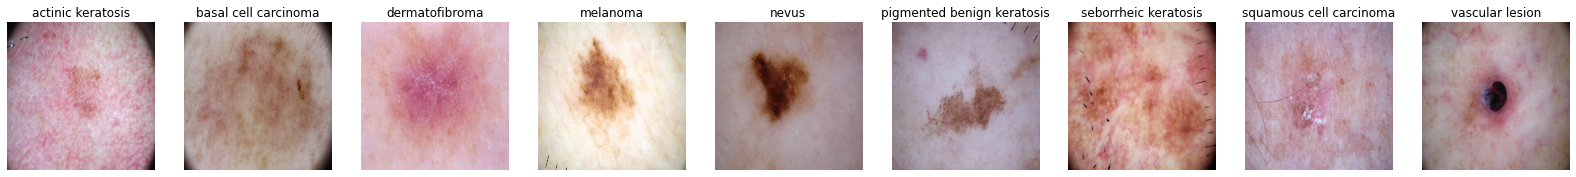

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(28, 10))
class_names = val_ds.class_names

for images, labels in val_ds.take(1):                       ##taking one batch
    labels_list  = list(labels.numpy())
    for i in range(9):                                      ## for each class
        img_idx = labels_list.index(i)                      ## find an image index which has the particular class number
        ax = plt.subplot(1, 9, i + 1)                       ## in 1x9 layout, assign the subplot
        plt.imshow(images[img_idx].numpy().astype("uint8")) ## show the image in that subplot
        plt.title(class_names[i])                           ## get the name of the class
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
- Let's create a CNN model, which can accurately detect 9 classes present in the dataset. 
- Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1).
- The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

In [14]:
num_classes = 9
NormalLayer = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))

# model
model = Sequential()
model.add(NormalLayer)

# first conv layer
model.add(Conv2D(32, kernel_size=(3, 3), padding="same",
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# second conv layer
model.add(Conv2D(64, kernel_size=(3, 3), padding="same",
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# third conv layer
model.add(Conv2D(128, kernel_size=(3, 3), padding="same",
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(256, activation='relu')) # fully connected

# softmax layer
model.add(Dense(num_classes, activation='softmax'))


### Compile the model


In [15]:
### Using sparseCategorical cross entropy as loss function and adam as the optimiser
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), ## as the target isnt one hot encoded
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 128)      

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 205s 409ms/step - loss: 2.1884 - accuracy: 0.2176 - val_loss: 1.9737 - val_accuracy: 0.3289
Epoch 2/20
56/56 [==============================] - 4s 75ms/step - loss: 1.8145 - accuracy: 0.3521 - val_loss: 1.7184 - val_accuracy: 0.3714
Epoch 3/20
56/56 [==============================] - 4s 73ms/step - loss: 1.5899 - accuracy: 0.4498 - val_loss: 1.5716 - val_accuracy: 0.4922
Epoch 4/20
56/56 [==============================] - 4s 73ms/step - loss: 1.4328 - accuracy: 0.4939 - val_loss: 1.4374 - val_accuracy: 0.5302
Epoch 5/20
56/56 [==============================] - 4s 72ms/step - loss: 1.3048 - accuracy: 0.5491 - val_loss: 1.4385 - val_accuracy: 0.5123
Epoch 6/20
56/56 [==============================] - 4s 73ms/step - loss: 1.2166 - accuracy: 0.5603 - val_loss: 1.3996 - val_accuracy: 0.5503
Epoch 7/20
56/56 [==============================] - 4s 72ms/step - loss: 1.1819 - accuracy: 0.5731 - val_loss: 1.4837 - val_accuracy: 0.5436
Epoch 8/20

### Visualizing training results

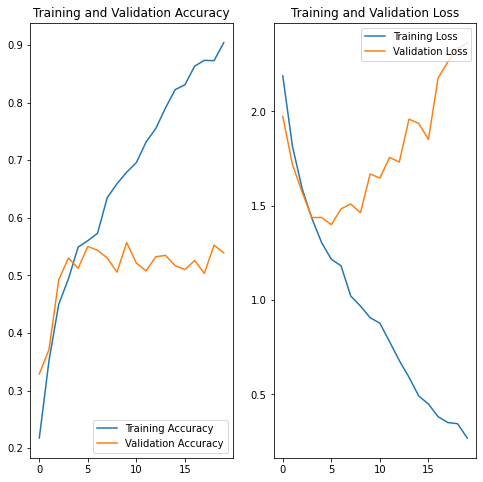

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings:
1. We can clearly see that the training accuracy has went till 90% and validation accuracy has at max played till 55% 
2. The same can be seen in validation and training loss, validation loss has increased on a whole.
3. We can conclude that this is the case of **OverFitting**

# Lets do some data Augmentation:
1. Random flip 
2. Random Rotation with prob of 0.5
3. Random zoom with probability of 0.2
4. Random contrast with probability of 0.2

In [19]:
# Choosing an appropriate data augumentation strategy. 

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.5),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2)
      
      
  ]
)

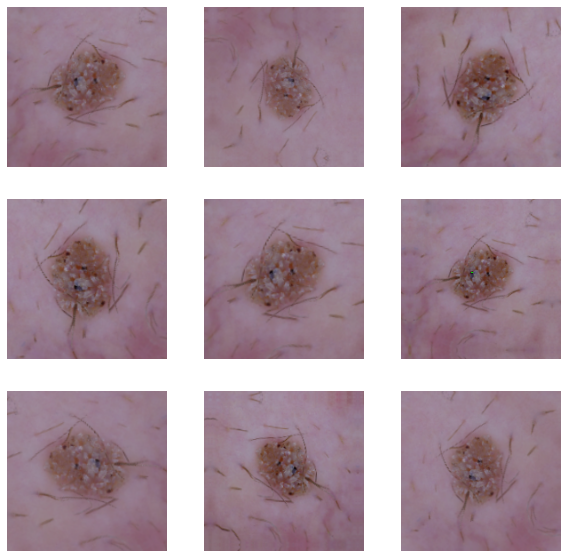

In [20]:
# lets see how augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[5].numpy().astype("uint8"))
    plt.axis("off")

## Lets use the data augmentation in the training pipeline and see if there is any improvement


In [25]:
num_classes = 9
NormalLayer = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))


# model
model1 = Sequential()

model1.add(data_augmentation)

model1.add(NormalLayer)

# first conv layer
model1.add(Conv2D(32, kernel_size=(3, 3), padding="same",
                 activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# second conv layer
model1.add(Conv2D(64, kernel_size=(3, 3), padding="same",
                 activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# third conv layer
model1.add(Conv2D(128, kernel_size=(3, 3), padding="same",
                 activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# flatten and put a fully connected layer
model1.add(Flatten())
model1.add(Dense(256, activation='relu')) # fully connected

# softmax layer
model1.add(Dense(num_classes, activation='softmax'))

model1.summary()




Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 45, 45, 128)      

### Compiling the model with same configuration as before

In [26]:
## Compiling the model
# opt = keras.optimizers.Adam(learning_rate=0.0009)
model1.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), ## as the target isnt one hot encoded
              metrics=['accuracy'])

### Training the model

In [27]:
## train the model for 20 epochs
epochs = 20
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 84ms/step - loss: 1.8958 - accuracy: 0.2991 - val_loss: 1.7409 - val_accuracy: 0.3870
Epoch 2/20
56/56 [==============================] - 4s 80ms/step - loss: 1.7017 - accuracy: 0.3778 - val_loss: 1.5896 - val_accuracy: 0.4206
Epoch 3/20
56/56 [==============================] - 4s 80ms/step - loss: 1.6037 - accuracy: 0.4107 - val_loss: 1.5279 - val_accuracy: 0.4474
Epoch 4/20
56/56 [==============================] - 4s 80ms/step - loss: 1.5436 - accuracy: 0.4431 - val_loss: 1.5291 - val_accuracy: 0.4362
Epoch 5/20
56/56 [==============================] - 5s 81ms/step - loss: 1.4713 - accuracy: 0.4782 - val_loss: 1.3975 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 4s 80ms/step - loss: 1.4515 - accuracy: 0.4844 - val_loss: 1.4022 - val_accuracy: 0.4855
Epoch 7/20
56/56 [==============================] - 5s 81ms/step - loss: 1.4193 - accuracy: 0.4972 - val_loss: 1.3940 - val_accuracy: 0.5123
Epoch 8/20
56

### Visualizing the results

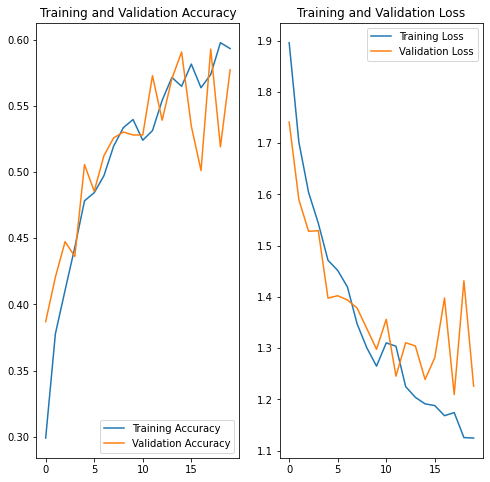

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings: 
1. We clearly see that the overfitting has come down as both training and validation accuracies are almost same. But this is the case of underfitting, as the training accuracy is not that great though the train and validation loss are almost the same.
2. Training accuracy is about 59.32% and validation accuracy is around 58%

### Lets find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

{'actinic keratosis': 114, 'basal cell carcinoma': 376, 'dermatofibroma': 95, 'melanoma': 438, 'nevus': 357, 'pigmented benign keratosis': 462, 'seborrheic keratosis': 77, 'squamous cell carcinoma': 181, 'vascular lesion': 139}


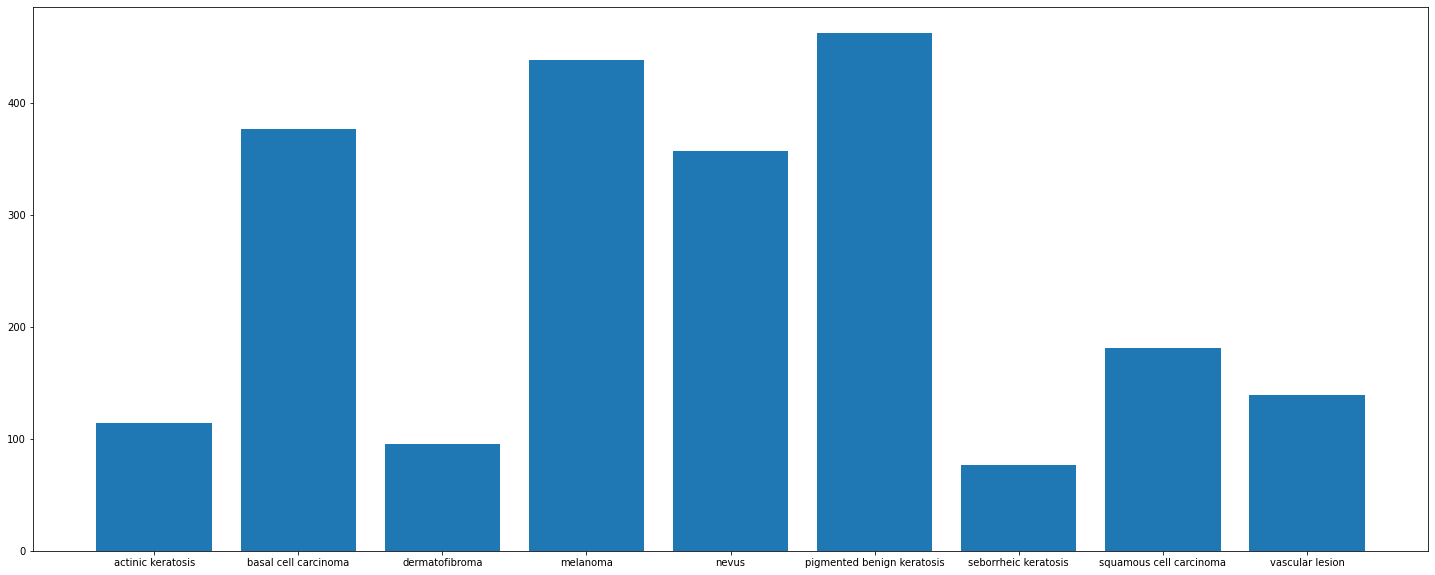

In [29]:
## Your code goes here.
path_to_training_dataset="/content/gdrive/MyDrive/Colab Notebooks/melanomaData/Train/"
import os
class_count = {}                                                ###create a map of class to sample count
for i in class_names:
  class_count[i] = len(os.listdir(path_to_training_dataset+i))

print(class_count)


## bar plot of counts 

import matplotlib.pyplot as plt
plt.figure(figsize=(25,10))
names = list(class_count.keys())
values = list(class_count.values())

plt.bar(range(len(class_count)), values, tick_label=names)
plt.show()

### **Findings from class counts:**
- We see that seborrheic keratosis with just 7 samples
- pigmented benign keratosis dominates other classes and has 462 samples


### **Rectifying class imbalance using Augmentor Library**
1. Lets have 500 images per class
2. Augmenting with just left and right rotation only with a probability of 0.7

In [ ]:
path_to_training_dataset="/content/gdrive/MyDrive/Colab Notebooks/melanomaData/Train/"
import Augmentor
for i in class_names: ## for each class lets add the new folder per class in AugmentedTrain folder
    p = Augmentor.Pipeline(path_to_training_dataset + i,output_directory = "/content/gdrive/MyDrive/Colab Notebooks/melanomaData/AugmentedTrain/" +i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/melanomaData/AugmentedTrain/actinic keratosis.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FF465F089D0>: 100%|██████████| 500/500 [00:23<00:00, 21.40 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/melanomaData/AugmentedTrain/basal cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF464133950>: 100%|██████████| 500/500 [00:22<00:00, 22.68 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/melanomaData/AugmentedTrain/dermatofibroma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF465F08710>: 100%|██████████| 500/500 [00:23<00:00, 21.21 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/melanomaData/AugmentedTrain/melanoma.

Processing <PIL.Image.Image image mode=RGB size=959x638 at 0x7FF465EB0450>: 100%|██████████| 500/500 [01:42<00:00,  4.89 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/melanomaData/AugmentedTrain/nevus.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF465EA6C10>: 100%|██████████| 500/500 [01:43<00:00,  4.85 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/melanomaData/AugmentedTrain/pigmented benign keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF5541D7A50>: 100%|██████████| 500/500 [00:22<00:00, 22.27 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/melanomaData/AugmentedTrain/seborrheic keratosis.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FF465F79FD0>: 100%|██████████| 500/500 [00:48<00:00, 10.31 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/melanomaData/AugmentedTrain/squamous cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF465E09910>: 100%|██████████| 500/500 [00:22<00:00, 22.47 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/melanomaData/AugmentedTrain/vascular lesion.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FF4640D6710>: 100%|██████████| 500/500 [00:22<00:00, 21.85 Samples/s]


Augmentor has stored the augmented images in the AugmentedTrain directory with each of the sub-directories of skin cancer types within it.. Lets take a look at total count of augmented images.

In [31]:
data_dir_train_aug = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/melanomaData/AugmentedTrain/")
image_count_train = len(list(data_dir_train_aug.glob('*/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train_aug, '*','*.jpg'))]
path_list_new ##printing all the paths of newly created images

['/content/gdrive/MyDrive/Colab Notebooks/melanomaData/AugmentedTrain/actinic keratosis/actinic keratosis_original_ISIC_0029781.jpg_34471461-879d-4401-939f-8ddc44df171c.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/melanomaData/AugmentedTrain/actinic keratosis/actinic keratosis_original_ISIC_0030344.jpg_d07a18cd-5243-4e42-9409-2180dc061e3c.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/melanomaData/AugmentedTrain/actinic keratosis/actinic keratosis_original_ISIC_0025953.jpg_0b47c16a-3a90-4c89-b0bf-725661241988.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/melanomaData/AugmentedTrain/actinic keratosis/actinic keratosis_original_ISIC_0027615.jpg_fc1eb900-990e-4e22-a9b7-0fc0f366a7b7.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/melanomaData/AugmentedTrain/actinic keratosis/actinic keratosis_original_ISIC_0030826.jpg_9f7f625d-5f0a-491d-a1d9-5b1c9663565a.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/melanomaData/AugmentedTrain/actinic keratosis/actinic keratosis_original_ISIC_00299

In [33]:
##printing the name of the class of each image path
lesion_list_new = [os.path.basename((os.path.dirname(y))) for y in glob(os.path.join(data_dir_train_aug, '*', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [34]:
##create a dataframe with the path of the image and its class name
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [35]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2

,Path,Label
0,/content/gdrive/MyDrive/Colab Notebooks/melano...,actinic keratosis
1,/content/gdrive/MyDrive/Colab Notebooks/melano...,actinic keratosis
2,/content/gdrive/MyDrive/Colab Notebooks/melano...,actinic keratosis
3,/content/gdrive/MyDrive/Colab Notebooks/melano...,actinic keratosis
4,/content/gdrive/MyDrive/Colab Notebooks/melano...,actinic keratosis
...,...,...
4495,/content/gdrive/MyDrive/Colab Notebooks/melano...,vascular lesion
4496,/content/gdrive/MyDrive/Colab Notebooks/melano...,vascular lesion
4497,/content/gdrive/MyDrive/Colab Notebooks/melano...,vascular lesion
4498,/content/gdrive/MyDrive/Colab Notebooks/melano...,vascular lesion


In [36]:
#getting the class counts
df2['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
squamous cell carcinoma       500
melanoma                      500
vascular lesion               500
pigmented benign keratosis    500
nevus                         500
dermatofibroma                500
seborrheic keratosis          500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Train the model on the data created using Augmentor

In [37]:
batch_size = 32
img_height = 180
img_width = 180

### Create a training dataset

In [38]:
data_dir_train_aug="/content/gdrive/MyDrive/Colab Notebooks/melanomaData/AugmentedTrain/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_aug,
  seed=123,
  validation_split = 0.2,
  subset = "training",## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 3600 files for training.


### Create a validation dataset

In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_aug,
  seed=123,
  validation_split = 0.2,
  subset = "validation",## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4500 files belonging to 9 classes.
Using 900 files for validation.


### Creating the Model

In [52]:
num_classes = 9
NormalLayer = layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3))


# model
model2 = Sequential()

model2.add(NormalLayer)

# first conv layer
model2.add(Conv2D(32, kernel_size=(3, 3), padding="same",
                 activation='relu'))
model2.add(Dropout(0.3))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# second conv layer
model2.add(Conv2D(64, kernel_size=(3, 3), padding="same",
                 activation='relu'))
model2.add(Dropout(0.3))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# third conv layer
model2.add(Conv2D(128, kernel_size=(3, 3), padding="same",
                 activation='relu'))
model2.add(Dropout(0.3))
model2.add(MaxPooling2D(pool_size=(2, 2)))


# flatten and put a fully connected layer
model2.add(Flatten())
model2.add(Dense(256, activation='relu')) # fully connected
model2.add(Dropout(0.5))

# softmax layer
model2.add(Dense(num_classes, activation='softmax'))

model2.summary()



Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_8 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
dropout_11 (Dropout)         (None, 180, 180, 32)      0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 90, 90, 64)        18496     
_________________________________________________________________
dropout_12 (Dropout)         (None, 90, 90, 64)        0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 45, 45, 64)       

### Compiling the new model with Dropout layers added newly

In [53]:
model2.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), ## as the target isnt one hot encoded
              metrics=['accuracy'])

### Training the model for 30 epochs

In [54]:
epochs = 30
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
113/113 [==============================] - 24s 192ms/step - loss: 2.0936 - accuracy: 0.2586 - val_loss: 1.8555 - val_accuracy: 0.3044
Epoch 2/30
113/113 [==============================] - 23s 189ms/step - loss: 1.6346 - accuracy: 0.3806 - val_loss: 1.7729 - val_accuracy: 0.3822
Epoch 3/30
113/113 [==============================] - 22s 188ms/step - loss: 1.4385 - accuracy: 0.4731 - val_loss: 1.5026 - val_accuracy: 0.4778
Epoch 4/30
113/113 [==============================] - 23s 189ms/step - loss: 1.2987 - accuracy: 0.5203 - val_loss: 1.4854 - val_accuracy: 0.5100
Epoch 5/30
113/113 [==============================] - 23s 190ms/step - loss: 1.1694 - accuracy: 0.5697 - val_loss: 1.3200 - val_accuracy: 0.5256
Epoch 6/30
113/113 [==============================] - 23s 190ms/step - loss: 1.0951 - accuracy: 0.6014 - val_loss: 1.2489 - val_accuracy: 0.5689
Epoch 7/30
113/113 [==============================] - 23s 189ms/step - loss: 1.0283 - accuracy: 0.6364 - val_loss: 1.2293 - val_ac

### Lets visualise the model results

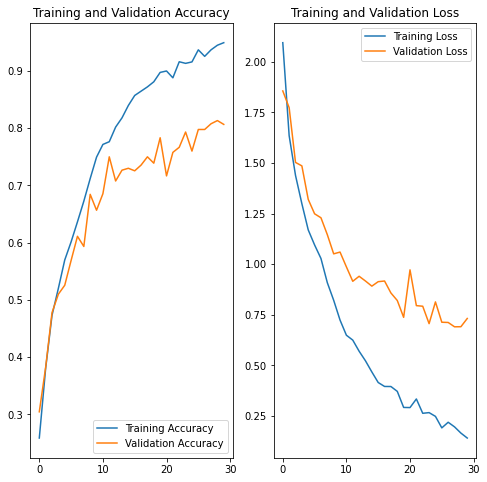

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations
1. We can see that the underfitting has been eliminated 
2. Now we have a max train accuracy around 94.5% and a max validation accuracy of around 80.4%
3. Both the train and test loss are below 1 . Validation loss around 0.7 least and train loss around 0.15 least

4. Based on the graphs we can say that its not completely overfitting but a decent model performs well over validation set. 
5. We can confirm that resampling the data using the Augmentor library has helped to overcome underfitting.

